In [101]:
from IPython.core.display import display, HTML
from IPython.display import clear_output
display(HTML("<style>.container { width:90% }</style>"))
# ------------------------------------------------------------------

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import os
import sys
import time
import json
import uuid 
from datetime import datetime

# -- AWS stuff -- 
import boto3
import sagemaker

# -- sklearn --
from sklearn.metrics import roc_curve, roc_auc_score, auc, roc_auc_score
%matplotlib inline 

In [102]:
# -- initialize the AFD client 
client = boto3.client('frauddetector')

# -- suffix is appended to detector and model name for uniqueness  
sufx   = datetime.now().strftime("%Y%m%d")


In [103]:
%store -r

### 1. Setup 
-----

***To get started ***  

1. Name the major components of Fraud Detector.
2. Plug in your ARN role 
3. Plug in your S3 Bucket and CSV File 

Then you can interactively exeucte the code cells in the notebook, no need to change anything unless you want to. 


<div class="alert alert-info"> <strong> Fraud Detector Components </strong>
Fraud Detector Components:  EVENT_TYPE is a business activity that you want evaluated for fraud risk. ENTITY_TYPE represents the "what or who" that is performing the event you want to evaluate. MODEL_NAME is the name of your supervised machine learning model that Fraud Detector trains on your behalf. DETECTOR_NAME is the name of the detector that contains the detection logic (model and rules) that you apply to events that you want to evaluate for fraud.

</div>


-----

### Bucket, File, and ARN Role

Bucket, ARN and Model Name Identify the following assets. S3_BUCKET is the name of the bucket where your file lives. S3_FILE is the URL to your s3 file. ARN_ROLE is the data access role "ARN" for the training data source.



<div class="alert alert-info"><strong> Bucket, ARN and Model Name </strong>

Identify the following assets. S3_BUCKET is the name of the bucket where your file lives. S3_FILE is the URL to your s3 file. ARN_ROLE is the data access role "ARN" for the training data source.

</div>

```
Note: To use Amazon Fraud Detector, you have to set up permissions that allow access to the Amazon Fraud Detector console and API operations. You also have to allow Amazon Fraud Detector to perform tasks on your behalf and to access resources that you own. We recommend creating an AWS Identify and Access Management (IAM) user with access restricted to. Amazon Fraud Detector operations and required permissions. You can add other permissions as needed. See "Create an IAM User and Assign Required Permissions" in the user's guide:
```
https://docs.aws.amazon.com/frauddetector/latest/ug/frauddetector.pdf


In [104]:
import sagemaker
role = sagemaker.get_execution_role()

In [105]:
# -- This is all you need to fill out. Once complete simply interactively run each code cell. --  

ENTITY_TYPE    = f"cf_customer_{sufx}"
ENTITY_DESC    = "entity description: {0}".format(sufx) 

EVENT_TYPE     = f"{project_prefix}_{sufx}"
EVENT_DESC     = "example event description: {0}".format(sufx) 

MODEL_NAME     = f"{project_prefix}_model_{sufx}"
MODEL_DESC     = "model trained on: {0}".format(sufx) 

DETECTOR_NAME  = f"{project_prefix}_detector_{sufx}"
DETECTOR_DESC  = "detects synthetic fraud events created: {0}".format(sufx) 

ARN_ROLE       = role
S3_BUCKET      = bucket
S3_FILE        = 'AdTalking-Fraud-Phase0/train/train-9000.csv' # s3_train_data_uri.split('/')[-1]
S3_FILE_LOC    = s3_train_data_uri


### 2. Profile Your Dataset 
-----

    
<div class="alert alert-info"> 💡 <strong> Profiling </strong>

The function below will: 1. profile your data, creating descriptive statistics, 2. perform basic data quality checks (nulls, unique variables, etc.), and 3. return summary statistics and the EVENT and MODEL schemas used to define your EVENT_TYPE and TRAIN your MODEL.


</div>

In [106]:
# --- no changes; just run this code block ---
def summary_stats(df):
    """ Generate summary statistics for a panda's data frame 
        Args:
            df (DataFrame): panda's dataframe to create summary statistics for.
        Returns:
            DataFrame of summary statistics, training data schema, event variables and event lables 
    """
    df = df.copy()
    rowcnt = len(df)
    df['EVENT_LABEL'] = df['EVENT_LABEL'].astype('str', errors='ignore')
    df_s1  = df.agg(['count', 'nunique']).transpose().reset_index().rename(columns={"index":"feature_name"})
    df_s1["null"] = (rowcnt - df_s1["count"]).astype('int64')
    df_s1["not_null"] = rowcnt - df_s1["null"]
    df_s1["null_pct"] = df_s1["null"] / rowcnt
    df_s1["nunique_pct"] = df_s1['nunique']/ rowcnt
    dt = pd.DataFrame(df.dtypes).reset_index().rename(columns={"index":"feature_name", 0:"dtype"})
    df_stats = pd.merge(dt, df_s1, on='feature_name', how='inner').round(4)
    df_stats['nunique'] = df_stats['nunique'].astype('int64')
    df_stats['count'] = df_stats['count'].astype('int64')
    
    # -- variable type mapper --  
    df_stats['feature_type'] = "UNKOWN"
    df_stats.loc[df_stats["dtype"] == object, 'feature_type'] = "CATEGORY"
    df_stats.loc[(df_stats["dtype"] == "int64") | (df_stats["dtype"] == "float64"), 'feature_type'] = "NUMERIC"
    df_stats.loc[df_stats["feature_name"].str.contains("ipaddress|ip_address|ipaddr"), 'feature_type'] = "IP_ADDRESS"
    df_stats.loc[df_stats["feature_name"].str.contains("email|email_address|emailaddr"), 'feature_type'] = "EMAIL_ADDRESS"
    df_stats.loc[df_stats["feature_name"] == "EVENT_LABEL", 'feature_type'] = "TARGET"
    df_stats.loc[df_stats["feature_name"] == "EVENT_TIMESTAMP", 'feature_type'] = "EVENT_TIMESTAMP"
    
    # -- variable warnings -- 
    df_stats['feature_warning'] = "NO WARNING"
    df_stats.loc[(df_stats["nunique"] != 2) & (df_stats["feature_name"] == "EVENT_LABEL"),'feature_warning' ] = "LABEL WARNING, NON-BINARY EVENT LABEL"
    df_stats.loc[(df_stats["nunique_pct"] > 0.9) & (df_stats['feature_type'] == "CATEGORY") ,'feature_warning' ] = "EXCLUDE, GT 90% UNIQUE"
    df_stats.loc[(df_stats["null_pct"] > 0.2) & (df_stats["null_pct"] <= 0.5), 'feature_warning' ] = "NULL WARNING, GT 20% MISSING"
    df_stats.loc[df_stats["null_pct"] > 0.5,'feature_warning' ] = "EXCLUDE, GT 50% MISSING"
    df_stats.loc[((df_stats['dtype'] == "int64" ) | (df_stats['dtype'] == "float64" ) ) & (df_stats['nunique'] < 0.2), 'feature_warning' ] = "LIKELY CATEGORICAL, NUMERIC w. LOW CARDINALITY"
   
    # -- target check -- 
    exclude_fields  = df_stats.loc[(df_stats['feature_warning'] != 'NO WARNING')]['feature_name'].to_list()
    event_variables = df_stats.loc[(~df_stats['feature_name'].isin(['EVENT_LABEL', 'EVENT_TIMESTAMP']))]['feature_name'].to_list()
    event_labels    = df["EVENT_LABEL"].unique().tolist()
    
    trainingDataSchema = {
        'modelVariables' : df_stats.loc[(df_stats['feature_type'].isin(['IP_ADDRESS', 'EMAIL_ADDRESS', 'CATEGORY', 'NUMERIC' ]))]['feature_name'].to_list(),
        'labelSchema'    : {
            'labelMapper' : {
                'FRAUD' : [df["EVENT_LABEL"].value_counts().idxmin()],
                'LEGIT' : [df["EVENT_LABEL"].value_counts().idxmax()]
            }
        }
    }
    
    
    model_variables = df_stats.loc[(df_stats['feature_type'].isin(['IP_ADDRESS', 'EMAIL_ADDRESS', 'CATEGORY', 'NUMERIC' ]))]['feature_name'].to_list()
   
    
    # -- label schema -- 
    label_map = {
        'FRAUD' : [df["EVENT_LABEL"].value_counts().idxmin()],
        'LEGIT' : [df["EVENT_LABEL"].value_counts().idxmax()]
    }
    
    
    print("--- summary stats ---")
    print(df_stats)
    print("\n")
    print("--- event variables ---")
    print(event_variables)
    print("\n")
    print("--- event labels ---")
    print(event_labels)
    print("\n")
    print("--- training data schema ---")
    print(trainingDataSchema)
    print("\n")
    
    return df_stats, trainingDataSchema, event_variables, event_labels

# -- connect to S3, snag file, and convert to a panda's dataframe --
# s3   = boto3.resource('s3')
# obj  = s3.Object(S3_BUCKET, S3_FILE)
# body = obj.get()['Body']
# df   = pd.read_csv(body)

df   = pd.read_csv(s3_train_data_uri)

# -- call profiling function -- 
df_stats, trainingDataSchema, eventVariables, eventLabels = summary_stats(df)


--- summary stats ---
      feature_name   dtype   count  nunique  null  not_null  null_pct  nunique_pct     feature_type feature_warning
0      EVENT_LABEL  object  180000        2     0    180000       0.0       0.0000           TARGET      NO WARNING
1           str_ip  object  180000    44650     0    180000       0.0       0.2481         CATEGORY      NO WARNING
2          str_app  object  180000      184     0    180000       0.0       0.0010         CATEGORY      NO WARNING
3       str_device  object  180000      143     0    180000       0.0       0.0008         CATEGORY      NO WARNING
4           str_os  object  180000      143     0    180000       0.0       0.0008         CATEGORY      NO WARNING
5      str_channel  object  180000      157     0    180000       0.0       0.0009         CATEGORY      NO WARNING
6  EVENT_TIMESTAMP  object  180000   110099     0    180000       0.0       0.6117  EVENT_TIMESTAMP      NO WARNING


--- event variables ---
['str_ip', 'str_app', 's

### 3. Create Variables
-----

<div class="alert alert-info"> 💡 <strong> Create Variables. </strong>

The following section will automatically create your modeling input variables and your model scoring variable for you. 

</div>

In [107]:
df_stats.loc[(df_stats['feature_type'].isin(['IP_ADDRESS', 'EMAIL_ADDRESS']))]

,feature_name,dtype,count,nunique,null,not_null,null_pct,nunique_pct,feature_type,feature_warning


In [108]:
# --- no changes just run this code block ---
def create_label(df, FRAUD_LABEL):
    """
    Returns a dictionary for the model labelSchema, by identifying the rare event as fraud / and common as not-fraud 
    
    Arguments:
    df          -- input dataframe 
    FRAUD_LABEL -- the name of the field that contains fraud label  
    
    Returns:
    labelSchema -- a dictionary containing labelKey & labelMapper 
    """
    label_summary = df[FRAUD_LABEL].value_counts()
    labelSchema = {'labelKey': FRAUD_LABEL,
                   "labelMapper" : { "FRAUD": [str(label_summary.idxmin())], 
                                     "LEGIT": [str(label_summary.idxmax())]}
                  }
    client.put_label(
                name = str(label_summary.idxmin()),
                description = 'FRAUD')
    
    client.put_label(
                name = str(label_summary.idxmax()),
                description = 'LEGIT')
    return labelSchema
    
# -- function to create all your variables --- 
def create_variables(df_stats, MODEL_NAME):
    """
    Returns a variable list of model input variables, checks to see if variable exists,
    and, if not, then it adds the variable to Fraud Detector 
    
    Arguments: 
    enrichment_features  -- dictionary of optional features, mapped to specific variable types enriched (CARD_BIN, USERAGENT)
    numeric_features     -- optional list of numeric field names 
    categorical_features -- optional list of categorical features 
    
    Returns:
    variable_list -- a list of variable dictionaries 
    
    """
    enrichment_features = df_stats.loc[(df_stats['feature_type'].isin(['IP_ADDRESS', 'EMAIL_ADDRESS']))].to_dict(orient="record")
    numeric_features = df_stats.loc[(df_stats['feature_type'].isin(['NUMERIC']))]['feature_name'].to_dict()
    categorical_features = df_stats.loc[(df_stats['feature_type'].isin(['CATEGORY']))]['feature_name'].to_dict()
    
    variable_list = []
    # -- first do the enrichment features
    for feature in enrichment_features: 
        variable_list.append( {'name' : feature['feature_name']})
        try:
            resp = client.get_variables(name=feature['feature_name'])
        except:
            print("Creating variable: {0}".format(feature['feature_name']))
            resp = client.create_variable(
                    name = feature['feature_name'],
                    dataType = 'STRING',
                    dataSource ='EVENT',
                    defaultValue = '<unknown>', 
                    description = feature['feature_name'],
                    variableType = feature['feature_type'] )
                
               
    # -- check and update the numeric features 
    for feature in numeric_features: 
        variable_list.append( {'name' : numeric_features[feature]})
        try:
            resp = client.get_variables(name=numeric_features[feature])
        except:
            print("Creating variable: {0}".format(numeric_features[feature]))
            resp = client.create_variable(
                    name = numeric_features[feature],
                    dataType = 'FLOAT',
                    dataSource ='EVENT',
                    defaultValue = '0.0', 
                    description = numeric_features[feature],
                    variableType = 'NUMERIC' )
             
    # -- check and update the categorical features 
    for feature in categorical_features: 
        variable_list.append( {'name' : categorical_features[feature]})
        try:
            resp = client.get_variables(name=categorical_features[feature])
        except:
            print("Creating variable: {0}".format(categorical_features[feature]))
            resp = client.create_variable(
                    name = categorical_features[feature],
                    dataType = 'STRING',
                    dataSource ='EVENT',
                    defaultValue = '<unknown>', 
                    description = categorical_features[feature],
                    variableType = 'CATEGORICAL' )
    
    
    return variable_list


model_variables = create_variables(df_stats, MODEL_NAME)
print("\n --- model variable dict --")
print(model_variables)


model_label = create_label(df, "EVENT_LABEL")
print("\n --- model label schema dict --")
print(model_label)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pandas/core/frame.py:1490: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  FutureWarning,



 --- model variable dict --
[{'name': 'str_ip'}, {'name': 'str_app'}, {'name': 'str_device'}, {'name': 'str_os'}, {'name': 'str_channel'}]

 --- model label schema dict --
{'labelKey': 'EVENT_LABEL', 'labelMapper': {'FRAUD': ['1'], 'LEGIT': ['0']}}


### 4. Create Entity and Event Types
-----
    
<div class="alert alert-info"> 💡 <strong> Entity and Event. </strong>
    
The following code block will automatically create your entity and event types for you.

</div>

In [109]:
eventLabels



['0', '1']

In [110]:
print(ENTITY_TYPE)
print(EVENT_TYPE)

cf_customer_20210905
adtalking_fraud_phase0_20210905


In [111]:
# --- no changes just run this code block ---
response = client.put_entity_type(
    name        = ENTITY_TYPE,
    description = ENTITY_DESC
)
print("-- create entity --")
print(response)


response = client.put_event_type (
    name           = EVENT_TYPE,
    eventVariables = eventVariables,
    labels         = eventLabels,
    entityTypes    = [ENTITY_TYPE])
print("-- create event type --")
print(response)

-- create entity --
{'ResponseMetadata': {'RequestId': '58b837e0-8b86-4d1f-9e7b-4050d1f3a4b5', 'HTTPStatusCode': 200, 'HTTPHeaders': {'date': 'Sun, 05 Sep 2021 13:58:36 GMT', 'content-type': 'application/x-amz-json-1.1', 'content-length': '2', 'connection': 'keep-alive', 'x-amzn-requestid': '58b837e0-8b86-4d1f-9e7b-4050d1f3a4b5'}, 'RetryAttempts': 0}}
-- create event type --
{'ResponseMetadata': {'RequestId': '3a9d1f7b-84ad-417c-9162-3e99643fdc60', 'HTTPStatusCode': 200, 'HTTPHeaders': {'date': 'Sun, 05 Sep 2021 13:58:36 GMT', 'content-type': 'application/x-amz-json-1.1', 'content-length': '2', 'connection': 'keep-alive', 'x-amzn-requestid': '3a9d1f7b-84ad-417c-9162-3e99643fdc60'}, 'RetryAttempts': 0}}


### 5. Create & Train your Model
-----
    
<div class="alert alert-info"> 💡 <strong> Train Model. </strong>

The following section will automatically train and activate your model for you. 

</div>

In [ ]:
# --- no changes; just run this code block. ---

# -- create our model --
response = client.create_model(
   description   =  MODEL_DESC,
   eventTypeName = EVENT_TYPE,
   modelId       = MODEL_NAME,
   modelType   = 'ONLINE_FRAUD_INSIGHTS')

print("-- initalize model --")
print(response)
# -- initializes the model, it's now ready to train -- 
response = client.create_model_version(
    modelId     = MODEL_NAME,
    modelType   = 'ONLINE_FRAUD_INSIGHTS',
    trainingDataSource = 'EXTERNAL_EVENTS',
    trainingDataSchema = trainingDataSchema,
    externalEventsDetail = {
        'dataLocation'     : S3_FILE_LOC,
        'dataAccessRoleArn': ARN_ROLE
    }
)
print("-- model training --")
print(response)


# -- model training takes time, we'll loop until it's complete  -- 
print("-- wait for model training to complete --")
stime = time.time()
while True:
    clear_output(wait=True)
    response = client.get_model_version(modelId=MODEL_NAME, modelType = "ONLINE_FRAUD_INSIGHTS", modelVersionNumber = '1.0')
    if response['status'] == 'TRAINING_IN_PROGRESS':
        print(f"current progress: {(time.time() - stime)/60:{3}.{3}} minutes")
        time.sleep(60)  # -- sleep for 60 seconds 
    if response['status'] != 'TRAINING_IN_PROGRESS':
        print("Model status : " +  response['status'])
        break
        
etime = time.time()

# -- summarize -- 
print("\n --- model training complete  --")
print("Elapsed time : %s" % (etime - stime) + " seconds \n"  )
print(response)


current progress: 13.1 minutes


In [ ]:
response = client.update_model_version_status (
    modelId = MODEL_NAME,
    modelType = 'ONLINE_FRAUD_INSIGHTS',
    modelVersionNumber = '1.0',
    status = 'ACTIVE'
)
print("-- activating model --")
print(response)

#-- wait until model is active 
print("--- waiting until model status is active ")
stime = time.time()
while True:
    clear_output(wait=True)
    response = client.get_model_version(modelId=MODEL_NAME, modelType = "ONLINE_FRAUD_INSIGHTS", modelVersionNumber = '1.0')
    if response['status'] != 'ACTIVE':
        print(f"current progress: {(time.time() - stime)/60:{3}.{3}} minutes")
        time.sleep(60)  # sleep for 1 minute 
    if response['status'] == 'ACTIVE':
        print("Model status : " +  response['status'])
        break
        
etime = time.time()
print("Elapsed time : %s" % (etime - stime) + " seconds \n"  )
print(response)

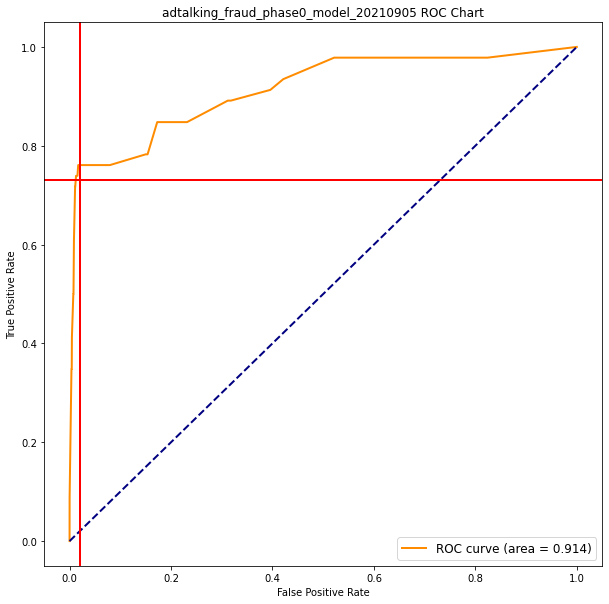

In [116]:
# -- model performance summary -- 
auc = client.describe_model_versions(
    modelId= MODEL_NAME,
    modelVersionNumber='1.0',
    modelType='ONLINE_FRAUD_INSIGHTS',
    maxResults=10
)['modelVersionDetails'][0]['trainingResult']['trainingMetrics']['auc']


df_model = pd.DataFrame(client.describe_model_versions(
    modelId= MODEL_NAME,
    modelVersionNumber='1.0',
    modelType='ONLINE_FRAUD_INSIGHTS',
    maxResults=10
)['modelVersionDetails'][0]['trainingResult']['trainingMetrics']['metricDataPoints'])


plt.figure(figsize=(10,10))
plt.plot(df_model["fpr"], df_model["tpr"], color='darkorange',
         lw=2, label='ROC curve (area = %0.3f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title( MODEL_NAME + ' ROC Chart')
plt.legend(loc="lower right",fontsize=12)
plt.axvline(x = 0.02 ,linewidth=2, color='r')
plt.axhline(y = 0.73 ,linewidth=2, color='r')
plt.show()

### 6. Create Detector, generate Rules and assemble your Detector

-----
    
<div class="alert alert-info"> 💡 <strong> Generate Rules, Create and Publish a Detector. </strong>
    
The following section will automatically generate a number of fraud, investigate and approve rules based on the false positive rate and score thresholds of your model. These are just example rules that you could create, it is recommended that you fine tune your rules specifically to your business use case.
</div>

In [117]:
# -- initialize your detector -- 
response = client.put_detector(detectorId  = DETECTOR_NAME, 
                               description = DETECTOR_DESC, 
                               eventTypeName = EVENT_TYPE )

print(response)

{'ResponseMetadata': {'RequestId': 'd215f4ff-201c-4e96-986f-b2874faa7e1a', 'HTTPStatusCode': 200, 'HTTPHeaders': {'date': 'Sun, 05 Sep 2021 23:16:30 GMT', 'content-type': 'application/x-amz-json-1.1', 'content-length': '2', 'connection': 'keep-alive', 'x-amzn-requestid': 'd215f4ff-201c-4e96-986f-b2874faa7e1a'}, 'RetryAttempts': 0}}


In [118]:
# -- make rules -- 
model_stat = df_model.round(decimals=2)  

m = model_stat.loc[model_stat.groupby(["fpr"])["threshold"].idxmax()] 

def make_rule(x):
    rule = ""
    if x['fpr'] <= 0.05: 
        rule = "${0}_insightscore > {1}".format(MODEL_NAME,x['threshold'])
    if x['fpr'] == 0.06:
        rule = "${0}_insightscore <= {1}".format(MODEL_NAME,x['threshold_prev'])
    return rule
    
m["threshold_prev"] = m['threshold'].shift(1)
m['rule'] = m.apply(lambda x: make_rule(x), axis=1)

m['outcome'] = "approve"
m.loc[m['fpr'] <= 0.03, "outcome"] = "fraud"
m.loc[(m['fpr'] > 0.03) & (m['fpr'] <= 0.05), "outcome"] = "investigate"

print (" --- score thresholds 1% to 6% --- ")
print(m[["fpr", "tpr", "threshold", "rule", "outcome"]].loc[(m['fpr'] > 0.0 ) & (m['fpr'] <= 0.06)].reset_index(drop=True))


 --- score thresholds 1% to 6% --- 
    fpr   tpr  threshold                                               rule outcome
0  0.01  0.50      960.0  $adtalking_fraud_phase0_model_20210905_insight...   fraud
1  0.02  0.74      915.0  $adtalking_fraud_phase0_model_20210905_insight...   fraud
2  0.03  0.76      875.0  $adtalking_fraud_phase0_model_20210905_insight...   fraud


In [119]:
# -- create outcomes -- 
def create_outcomes(outcomes):
    """ create Fraud Detector Outcomes 
    
    """   
    for outcome in outcomes:
        print("creating outcome variable: {0} ".format(outcome))
        response = client.put_outcome(
                          name=outcome,
                          description=outcome)

# -- get distinct outcomes 
outcomes = m["outcome"].unique().tolist()

create_outcomes(outcomes)

creating outcome variable: fraud 
creating outcome variable: approve 


In [120]:
rule_set = m[(m["fpr"] > 0.0) & (m["fpr"] <= 0.06)][["outcome", "rule"]].to_dict('records')
rule_list = []
for i, rule in enumerate(rule_set):
    ruleId = "rule{0}_{1}".format(i, MODEL_NAME)
    rule_list.append({"ruleId": ruleId, 
                      "ruleVersion" : '1',
                      "detectorId"  : DETECTOR_NAME
        
    })
    print("creating rule: {0}: IF {1} THEN {2}".format(ruleId, rule["rule"], rule['outcome']))
    try:
        response = client.create_rule(
            ruleId = ruleId,
            detectorId = DETECTOR_NAME,
            expression = rule['rule'],
            language = 'DETECTORPL',
            outcomes = [rule['outcome']]
            )
    except:
        print("this rule already exists in this detector")
rule_list    

creating rule: rule0_adtalking_fraud_phase0_model_20210905: IF $adtalking_fraud_phase0_model_20210905_insightscore > 960.0 THEN fraud
creating rule: rule1_adtalking_fraud_phase0_model_20210905: IF $adtalking_fraud_phase0_model_20210905_insightscore > 915.0 THEN fraud
creating rule: rule2_adtalking_fraud_phase0_model_20210905: IF $adtalking_fraud_phase0_model_20210905_insightscore > 875.0 THEN fraud


[{'ruleId': 'rule0_adtalking_fraud_phase0_model_20210905',
  'ruleVersion': '1',
  'detectorId': 'adtalking_fraud_phase0_detector_20210905'},
 {'ruleId': 'rule1_adtalking_fraud_phase0_model_20210905',
  'ruleVersion': '1',
  'detectorId': 'adtalking_fraud_phase0_detector_20210905'},
 {'ruleId': 'rule2_adtalking_fraud_phase0_model_20210905',
  'ruleVersion': '1',
  'detectorId': 'adtalking_fraud_phase0_detector_20210905'}]

In [121]:
client.create_detector_version(
    detectorId = DETECTOR_NAME,
    rules = rule_list,
    modelVersions = [{"modelId":MODEL_NAME, 
                      "modelType" : "ONLINE_FRAUD_INSIGHTS",
                      "modelVersionNumber" : "1.0"}],
    ruleExecutionMode = 'FIRST_MATCHED'
    )

print("\n -- detector created -- ")
print(response) 



 -- detector created -- 
{'rule': {'detectorId': 'adtalking_fraud_phase0_detector_20210905', 'ruleId': 'rule2_adtalking_fraud_phase0_model_20210905', 'ruleVersion': '1'}, 'ResponseMetadata': {'RequestId': 'df7dec3f-ac49-43c1-9c57-74d43dc25087', 'HTTPStatusCode': 200, 'HTTPHeaders': {'date': 'Sun, 05 Sep 2021 23:18:08 GMT', 'content-type': 'application/x-amz-json-1.1', 'content-length': '139', 'connection': 'keep-alive', 'x-amzn-requestid': 'df7dec3f-ac49-43c1-9c57-74d43dc25087'}, 'RetryAttempts': 0}}


In [122]:
response = client.update_detector_version_status(
    detectorId= DETECTOR_NAME,
    detectorVersionId='1',
    status='ACTIVE'
)
print("\n -- detector activated -- ")
print(response)


 -- detector activated -- 
{'ResponseMetadata': {'RequestId': '58fbc5fd-1d14-443f-b405-499f90914142', 'HTTPStatusCode': 200, 'HTTPHeaders': {'date': 'Sun, 05 Sep 2021 23:18:24 GMT', 'content-type': 'application/x-amz-json-1.1', 'content-length': '2', 'connection': 'keep-alive', 'x-amzn-requestid': '58fbc5fd-1d14-443f-b405-499f90914142'}, 'RetryAttempts': 0}}


### 7. Make Predictions 
-----
    
<div class="alert alert-info"> 💡 <strong> Make Predictions. </strong>
    
The following section will apply your detector to the first 10 records in your training dataset. To apply your detector to more simply change the record_count, alternatively you can specify the full training data with the following: 

</div>

```python

record_count = df.shape()[0]

```

### 테스트 데이터로 추론

EVENT_TIMESTAMP를 FD 에서 요구하는 ISO-8601 Datetime format으로 변경 합니다.

In [168]:
import pandas as pd


date_cols = ['EVENT_TIMESTAMP']
test_df = pd.read_csv(test_local_path, parse_dates = date_cols)
print("test_df : ", test_df.shape)
print("test_df columns : ", test_df.columns)
test_df = test_df.sample(n=100, random_state=100)
test_df.head(2)

test_df :  (20000, 7)
test_df columns :  Index(['EVENT_LABEL', 'str_ip', 'str_app', 'str_device', 'str_os', 'str_channel', 'EVENT_TIMESTAMP'], dtype='object')


,EVENT_LABEL,str_ip,str_app,str_device,str_os,str_channel,EVENT_TIMESTAMP
2917,0,str_93021,str_3,str_1,str_8,str_280,2017-11-09 00:08:26
2234,0,str_16464,str_15,str_1,str_15,str_386,2017-11-09 08:58:44


In [173]:
# Convert to ISO-8601 Datetime format, # timestampStr = '2020-07-13T23:18:21Z'
# timestampStr_list = test_df['EVENT_TIMESTAMP'].apply(lambda x: x.strftime('%Y-%m-%dT%H:%M:%SZ'))
# record_count = test_df.shape[0]
# print("record_count: ", record_count)
# pred_data = test_df[eventVariables].head(record_count).astype(str).to_dict(orient='records')

timestampStr_list = test_df['EVENT_TIMESTAMP'].apply(lambda x: x.strftime('%Y-%m-%dT%H:%M:%SZ'))
record_count = test_df.shape[0]
print("record_count: ", record_count)
pred_data = test_df[eventVariables].head(record_count).astype(str).to_dict(orient='records')

record_count:  100


In [174]:
%%time 
# -- this will apply your detector to the first 10 records of your trainig dataset. -- 
predicted_dat = []
for rec , timestampStr in zip(pred_data, timestampStr_list):
    # print(timestampStr)
    eventId = uuid.uuid1()
    pred = client.get_event_prediction(detectorId=DETECTOR_NAME, 
                                       detectorVersionId='1',
                                       eventId = str(eventId),
                                       eventTypeName = EVENT_TYPE,
                                       eventTimestamp = timestampStr, 
                                       entities = [{'entityType': ENTITY_TYPE, 
                                                    'entityId':str(eventId.int)}],
                                       eventVariables=rec) 


    
    rec["score"]   = pred['modelScores'][0]['scores']["{0}_insightscore".format(MODEL_NAME)]
#    rec["outcome"] = pred['ruleResults'][0]['outcomes']
    predicted_dat.append(rec)
 



CPU times: user 153 ms, sys: 19 ms, total: 172 ms
Wall time: 16.1 s


In [177]:
# -- review your predictons -- 
predictions = pd.DataFrame(predicted_dat)
predictions.head()

,str_ip,str_app,str_device,str_os,str_channel,score
0,str_93021,str_3,str_1,str_8,str_280,3.0
1,str_16464,str_15,str_1,str_15,str_386,61.0
2,str_99519,str_2,str_1,str_22,str_435,61.0
3,str_15643,str_9,str_1,str_19,str_466,235.0
4,str_62916,str_3,str_1,str_19,str_280,3.0


array([[<AxesSubplot:title={'center':'score'}>]], dtype=object)

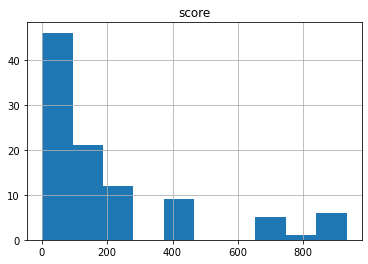

In [178]:
# score의 분포 확인
predictions.hist()

In [181]:
import numpy as np

def show_test_predictions(predictions, threshold):
    pred = predictions.copy()    
    pred['EVENT_LABEL'] = pred.score.apply(lambda x: np.where(x < threshold,0,1))
    print("# of kinds: \n", pred.EVENT_LABEL.value_counts())    
    
    return pred

pred = show_test_predictions(predictions, threshold= 500)


# of kinds: 
 0    88
1    12
Name: EVENT_LABEL, dtype: int64


## 평가 지표 생성
- ROC-AUC 
    - 참값과 추론의 score (1000으로 나누어서 예측 확률값으로 변경) 를 사용하여 계산
        - **훈련 데이터시에 0.96 이었고, 아래 테스트 테이터는 0.93 으로 비슷한 수치를 기록함
- F1, Precsion, Recall, Accuracy를 확인 
- Confusion Matrixa 확인

 ### ROC_AUC SCORE ### 
0.98989898989899

 ### F1 SCORE ### 
              precision    recall  f1-score   support

           0       0.89      1.00      0.94        88
           1       1.00      0.08      0.15        12

    accuracy                           0.89       100
   macro avg       0.94      0.54      0.55       100
weighted avg       0.90      0.89      0.85       100

[[88 11]
 [ 0  1]]


NameError: name 'np' is not defined

<Figure size 432x288 with 0 Axes>

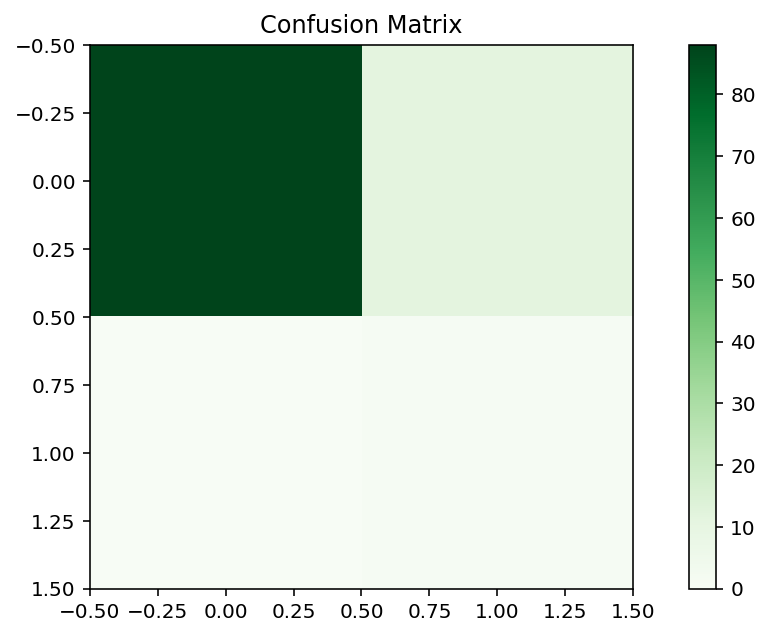

In [188]:
from sklearn.metrics import classification_report, roc_auc_score
from IPython.display import display as dp
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from src.p_utils import plot_conf_mat     
%matplotlib inline
%config InlineBackend.figure_format='retina'


def compute_f1(pred, test_df, label_col):
    test = test_df.copy()
    test= test.reset_index(drop=True)
    #test['label'] = test.EVENT_LABEL.apply(lambda x: np.where(x == 'fraud', 1,0))
    
    print(" ### ROC_AUC SCORE ### ")
    print(roc_auc_score(test[label_col], pred.score / 1000))
    print("\n ### F1 SCORE ### ")    
    print(classification_report(pred[label_col], test[label_col]))
    
    cm = confusion_matrix(y_true= test[label_col], y_pred= pred[label_col])

    plt.figure()
    fig, ax = plt.subplots(figsize=(10,5))
    plot_conf_mat(cm, 
                  classes=['fraud','legit'], 
                  title='Confusion Matrix')
    plt.show()    
    return test


compute_f1(pred, test_df, label_col='EVENT_LABEL')